# Case 17 - Tree-based methods - Part 2

## Business Problem

You are an analyst at a Colombian EPS. This company has identified a lot of problems arising from people developing heart deseases. So, the company has decided to build a model capable of classifying the risk that a patient has of developing these deseases.

### Packages Import

In [1]:
!pip install graphviz==0.19.1

     |████████████████████████████████| 46 kB 2.8 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pydotplus==2.0.2

     |████████████████████████████████| 278 kB 17.5 MB/s 
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=afb15d88205b7ef80137fb1b07f12fc2ab0914a165706bd0c0880073e1770a9a
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from graphviz import Source
from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image

### Data Import

The information was downloaded from a dataset available [online](https://biolincc.nhlbi.nih.gov/studies/framcohort/).

In [4]:
df_heart_disease = pd.read_csv(r'./data/framingham.csv')
df_heart_disease.head(5)

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

### EDA and Data Cleaning

In [5]:
#Droping education column
df_heart_disease.drop(columns='education',inplace=True)

#Droping the observations that have at least one missing value
df_heart_disease.dropna(axis=0,inplace=True)

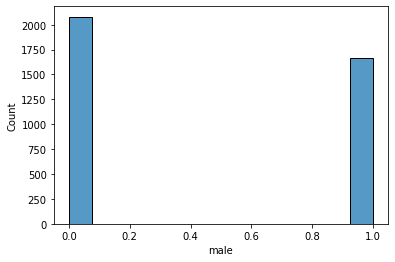

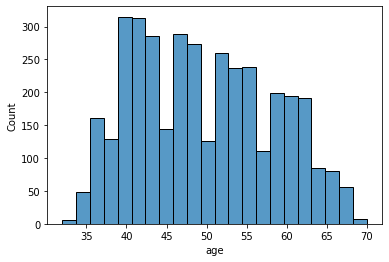

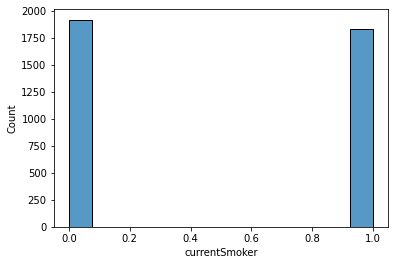

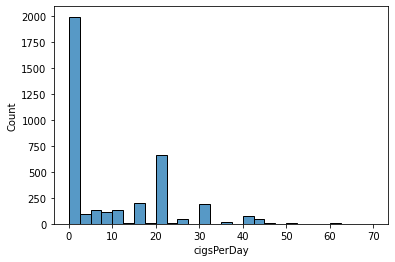

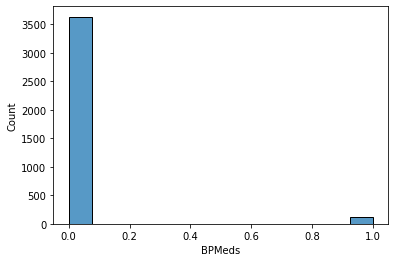

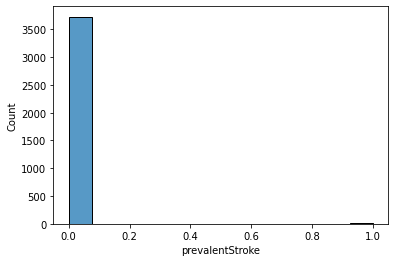

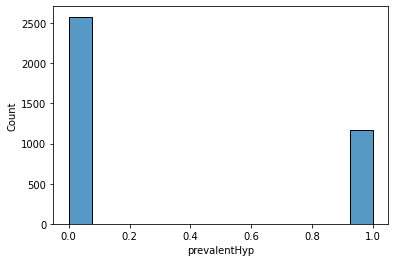

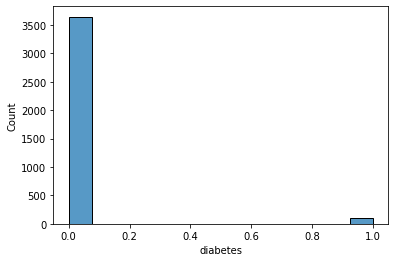

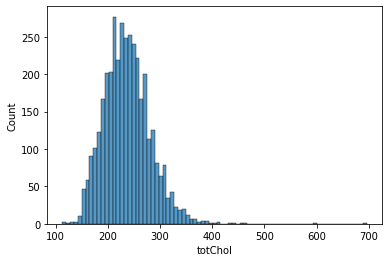

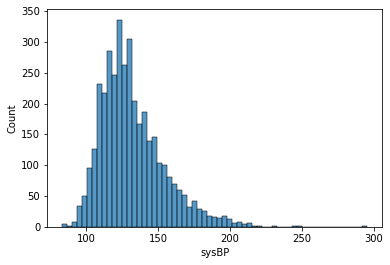

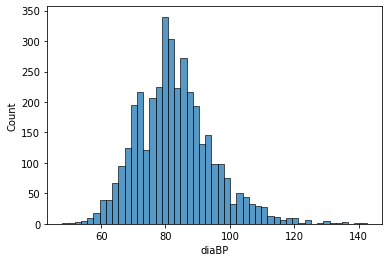

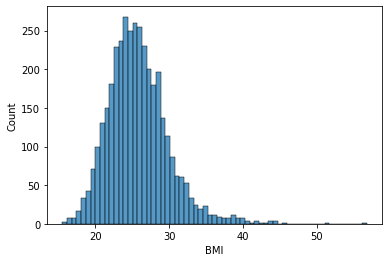

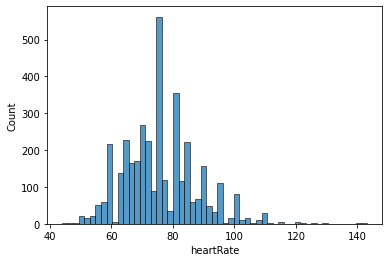

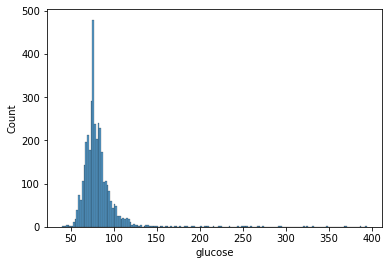

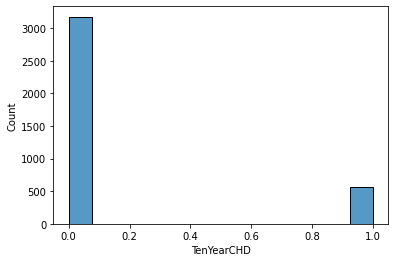

In [6]:
for column in df_heart_disease.columns:
    sns.histplot(x= column,data = df_heart_disease)
    plt.show()

In [7]:
df_heart_disease_No = df_heart_disease[df_heart_disease['TenYearCHD']==0].sample(n=600,random_state=2)
df_heart_disease_Yes = df_heart_disease[df_heart_disease['TenYearCHD']==1]
df_heart_disease_sample = pd.concat([df_heart_disease_No,df_heart_disease_Yes],axis=0)
df_heart_disease_sample = df_heart_disease_sample.sample(frac = 1)
df_heart_disease_sample.reset_index( drop=True, inplace=True)
df_heart_disease_sample.head(5)

male  age  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     0   53              1         9.0     0.0                0   
1     1   50              1        20.0     0.0                0   
2     0   52              0         0.0     0.0                0   
3     0   47              0         0.0     0.0                0   
4     0   40              0         0.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    210.0  132.0   84.5  27.08      110.0     84.0   
1             0         0    265.0  110.0   65.0  24.45       69.0     70.0   
2             0         0    265.0  137.5   84.5  26.91       72.0     86.0   
3             0         0    234.0  127.5   83.5  27.65       85.0     89.0   
4             0         0    230.0  127.0   72.0  29.62       85.0     70.0   

   TenYearCHD  
0           1  
1           0  
2           0  
3           0  
4           0

<AxesSubplot:xlabel='TenYearCHD', ylabel='Count'>

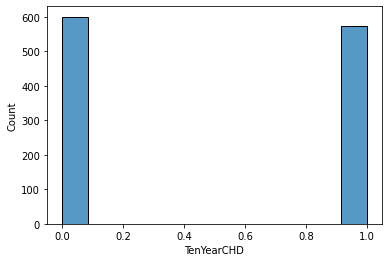

In [8]:
sns.histplot(x= 'TenYearCHD',data = df_heart_disease_sample)

### Train - Test Split

In [9]:

X_train, X_test, Y_train, Y_test = train_test_split(df_heart_disease_sample.drop(columns='TenYearCHD'), df_heart_disease_sample['TenYearCHD'] , test_size=0.2, random_state=555555555)

## Bagging

One of the problems that decision trees have is their high variance. Now, if we have $n$ random variables $Z_1$,$Z_2$, $...$, $Z_n$, each of them with a variance equal to $\sigma^2$, then the average of those random variables $\bar Z$ will have a variance equal to $\sigma^2/n$. Then, by taking the average of a set of observations, variance can be reduced. Taking that into account, tha bagging method relies on creating multiple prediction models and then averaging their predictions in order to reduce the variance of the estimation.

In order to apply the bagging methods, $B$ different training sets should be used in order to create $B$ different estimation models $\hat f_1(x)$,$\hat f_2(x)$,$...$,$\hat f_B(x)$. Then, the prediction given would be the average of the prediction given by the $B$ models. However, it is not easy to get many different training sets to fit all of the different models. On that account, to fit models using different training sets, the **bootstrap** method can be used to create different training sets by repeatedly taking samples from the original training set.

While bagging can improve predictions for many regression and classification methods, it is particularly useful for decision trees. To apply bagging to regression trees, we simply construct B regression trees using B bootstrapped training sets, and average the resulting predictions. For classification problems, this averaging is made by majority vote; each tree classifies an observation and then this observation is classified as beign from the class that appeared the most in the trees' classification. The trees that are created for bagging are grown deep, and are not pruned. Hence each individual tree has high variance, but low bias. Averaging these B trees reduces the variance. Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

#### Bagging Fitting

In [10]:
bc = BaggingClassifier()
bc_res = bc.fit(X_train, Y_train)

#### Bagging validation metrics

In [11]:
scores = cross_val_score(bc_res, X_train, Y_train, cv=10, scoring='accuracy')
print(scores)
print("Accuracy: ",scores.mean())

scores = cross_val_score(bc_res,  X_train, Y_train, cv=10, scoring='recall')
print("Recall: ",scores.mean())

scores = cross_val_score(bc_res,  X_train, Y_train, cv=10, scoring='roc_auc')
print("Roc_auc: ",scores.mean())

[0.58510638 0.59574468 0.67021277 0.61702128 0.65957447 0.55319149
 0.54255319 0.55913978 0.58064516 0.66666667]
Accuracy:  0.6029855868222376
Recall:  0.57770390070922
Roc_auc:  0.6345193165639905


#### Bagging Model Adjustments

In [12]:
bc = BaggingClassifier()

param_grid_bc = {'n_estimators': [10,20,50,100,150,200,250,300,350,400,450,500]}

grid_bc = GridSearchCV(bc, param_grid_bc, scoring='recall', cv=10, n_jobs=-1)

grid_bc.fit(X_train, Y_train)

print("Best Bagging parameters: ",grid_bc.best_estimator_)
print('Best Bagging Recall score: %.3f' % np.abs(grid_bc.best_score_))

Best Bagging parameters:  BaggingClassifier(n_estimators=350)
Best Bagging Recall score: 0.665


#### Bagging Testing



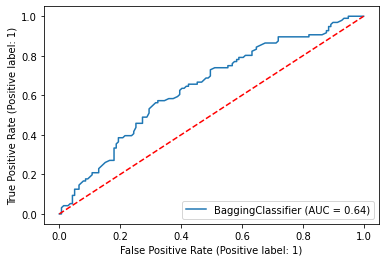

In [13]:
bc = BaggingClassifier(n_estimators=300)
bc_res = bc.fit(X_train, Y_train)

RocCurveDisplay.from_estimator(bc_res, X_test, Y_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")


### Bagging Visualization

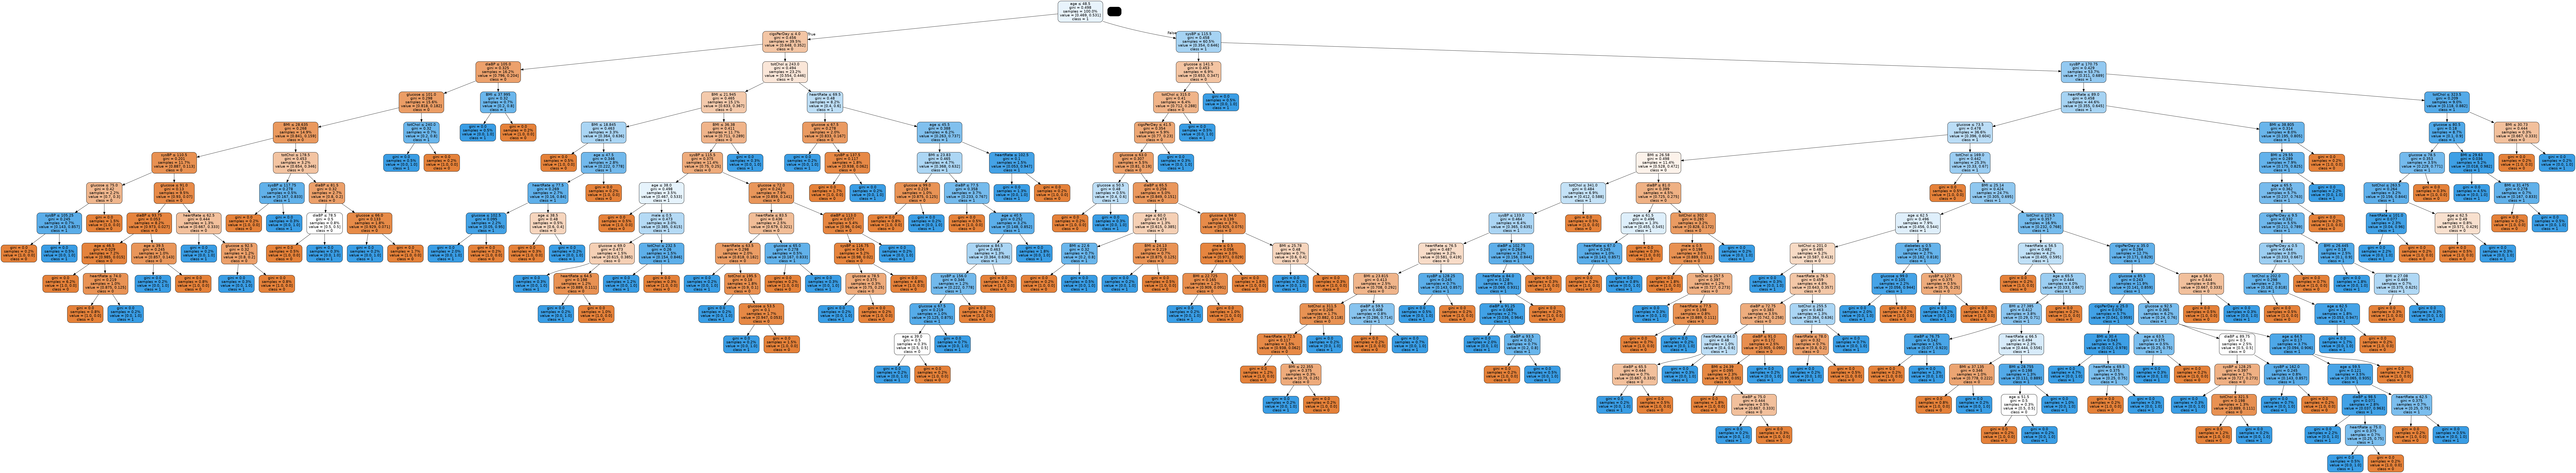

In [14]:
dot_data = StringIO()


export_graphviz(bc_res.estimators_[0], out_file=dot_data, feature_names = X_train.columns,
                class_names=['0', '1'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Random Forest

Random forests are an improvement over bagging by making a small change that decorrelates the different decision trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of $p$ predictors is chosen as split candidates from the full set of $m$ predictors. The split is allowed to use only one of those $p$ predictors. A fresh sample of $p$ predictors is taken at each split, and typically we choose $p$ ≈ $\sqrt m$, that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors.

With these trick, the trees that are created will be very different, as each split of each tree will only consider a subset of predictors. If all of the trees that are created take into account all of the predictors in each split, those trees will be very similar, as the first splits will be made with the most relevant variables. Therefore, the trees generated by the bagging method will be higly correlated, and averaging higly correlated predictions does not reduce the variance of the prediction that much.

#### Random Forest Fitting

In [15]:
rfc = RandomForestClassifier()
rfc_res = rfc.fit(X_train, Y_train)

#### Random Forest validation metrics

In [16]:
scores = cross_val_score(rfc_res,  X_train, Y_train, cv=10, scoring='accuracy')
print(scores)
print("Accuracy: ",scores.mean())

scores = cross_val_score(rfc_res,  X_train, Y_train, cv=10, scoring='recall')
print("Recall: ",scores.mean())

scores = cross_val_score(rfc_res,  X_train, Y_train, cv=10, scoring='roc_auc')
print("Roc_auc: ",scores.mean())

[0.61702128 0.63829787 0.62765957 0.69148936 0.68085106 0.72340426
 0.57446809 0.55913978 0.59139785 0.56989247]
Accuracy:  0.6273621596888584
Recall:  0.6383421985815602
Roc_auc:  0.669523105411984


#### Random Forest Model Adjustments

In [17]:
rfc = RandomForestClassifier()

param_grid_rfc = {'n_estimators': [10,20,50,100, 150, 200], 
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]}

grid_rfc = GridSearchCV(rfc, param_grid_rfc, scoring='recall', cv=10, n_jobs=-1)

grid_rfc.fit(X_train, Y_train)

print("Best Random Forest parameters: ",grid_rfc.best_estimator_)
print('Best Random Forest Recall score: %.3f' % np.abs(grid_rfc.best_score_))

Best Random Forest parameters:  RandomForestClassifier(max_depth=110, max_features=2, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=10)
Best Random Forest Recall score: 0.680


#### Random Forest Testing

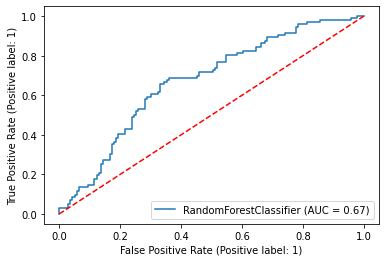

In [18]:
rfc = RandomForestClassifier(max_depth=110, max_features=2, min_samples_leaf=5,min_samples_split=10,n_estimators = 10)
rfc_res = rfc.fit(X_train, Y_train)

RocCurveDisplay.from_estimator(rfc_res, X_test, Y_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

### Random Forest Visualization

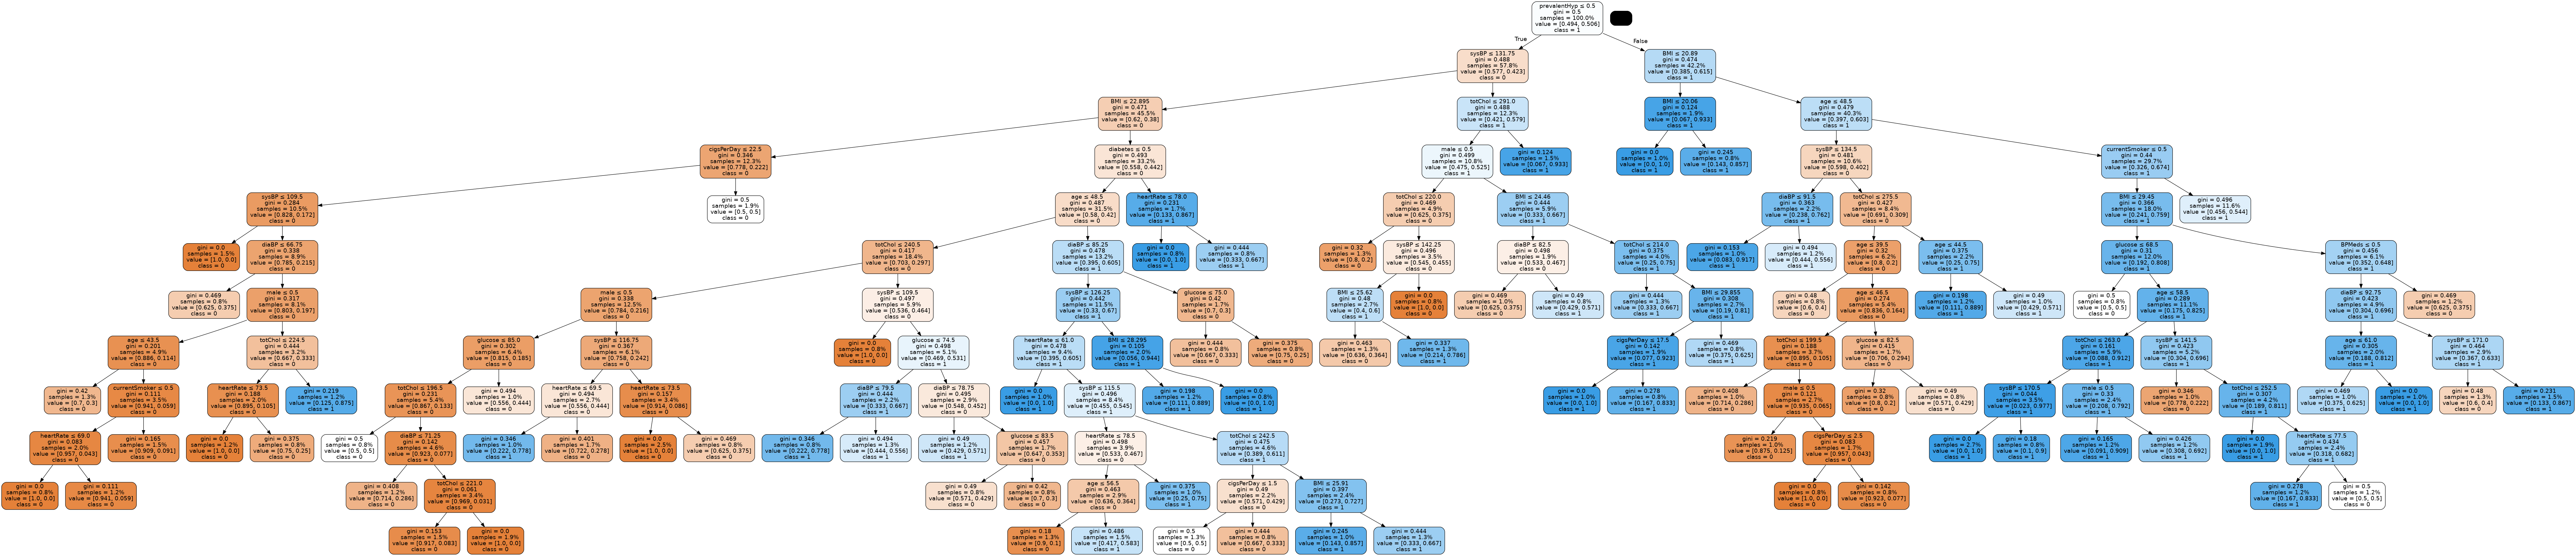

In [19]:
dot_data = StringIO()


export_graphviz(rfc_res.estimators_[0], out_file=dot_data, feature_names = X_train.columns,
                class_names=['0', '1'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Boosting

Boosting is a method that can be used for many regression and classification models, however we will limit ourselves to talk about boosting when applied to decision trees. Boosting works in a similar way when compared to bagging as it creates different decision trees. However, boosting creates them in a sequential way, i.e. each tree is grown with information given from the previous tree that was created. Boosting does not involve bootstrap sampling; instead each
tree is fit on a modified version of the original data set.

Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly by correcting the errors that the previous tree had.

#### Boosting Fitting

In [20]:
gbc = GradientBoostingClassifier()
gbc_res = gbc.fit(X_train, Y_train)

#### Boosting validation metrics

In [21]:
scores = cross_val_score(gbc_res,  X_train, Y_train, cv=10, scoring='accuracy')
print(scores)
print("Accuracy: ",scores.mean())

scores = cross_val_score(gbc_res, X_train, Y_train, cv=10, scoring='recall')
print("Recall: ",scores.mean())

scores = cross_val_score(gbc_res,  X_train, Y_train, cv=10, scoring='roc_auc')
print("Roc_auc: ",scores.mean())

[0.53191489 0.55319149 0.61702128 0.69148936 0.70212766 0.68085106
 0.58510638 0.55913978 0.59139785 0.58064516]
Accuracy:  0.6092884923358499
Recall:  0.6152039007092198
Roc_auc:  0.641512406426936


#### Boosting validation metrics

In [22]:
gbc = GradientBoostingClassifier()

param_grid_gbc = {'n_estimators': [10,20,50,100, 150, 200], 
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4, 5],
    'learning_rate': np.linspace(0.001,0.2,10)}

grid_gbc = GridSearchCV(gbc, param_grid_gbc, scoring='recall', cv=10, n_jobs=-1)

grid_gbc.fit(X_train, Y_train)

print("Best Boosting parameters: ",grid_gbc.best_estimator_)
print('Best Boosting Recall score: %.3f' % np.abs(grid_gbc.best_score_))

Best Boosting parameters:  GradientBoostingClassifier(learning_rate=0.001, max_depth=80, max_features=2,
                           n_estimators=10)
Best Boosting ROC_AUC score: 1.000


#### Boosting Testing

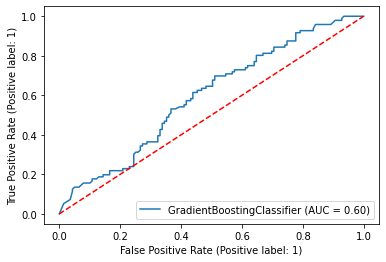

In [23]:
gbc = GradientBoostingClassifier(learning_rate=0.001, max_depth=80,max_features=2, n_estimators=10)
gbc_res = gbc.fit(X_train, Y_train)

RocCurveDisplay.from_estimator(gbc_res, X_test, Y_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

### Model Comparision

In [24]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train,Y_train)

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dtc_res = dtc.fit(X_train, Y_train)


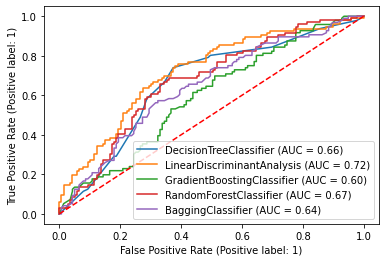

In [25]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(dtc_res, X_test, Y_test, ax = ax)
RocCurveDisplay.from_estimator(lda, X_test, Y_test,ax=ax)
RocCurveDisplay.from_estimator(gbc_res, X_test, Y_test, ax = ax)
RocCurveDisplay.from_estimator(rfc_res, X_test, Y_test, ax = ax)
RocCurveDisplay.from_estimator(bc_res, X_test, Y_test, ax = ax)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=96262903-a28f-4719-a328-dc59e3cfa77f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>